# 5 Minute Introduction into Emukit

In this tutorial we will use Emukit in the simplest way possible, just to start looking around and understanding how Emukit components fit together.

In [1]:
import numpy as np
import GPy

from emukit.model_wrappers import GPyModelWrapper
from emukit.experimental_design.model_based.experimental_design_loop import ExperimentalDesignLoop
from emukit.core import ParameterSpace, ContinuousParameter
from emukit.core.loop import UserFunctionWrapper

Let's assume we have built a [GPy](https://github.com/SheffieldML/GPy) model of some function that we would like to understand. In this toy example we will use `sin(x)`, but of course the actual objective function can be much more complex.

In [2]:
x_min = -30.0
x_max = 30.0

X = np.random.uniform(x_min, x_max, (10, 1))
Y = np.sin(X) + np.random.randn(10, 1) * 0.05
gpy_model = GPy.models.GPRegression(X, Y)

Now we would like to collect more data about this function's behavior. Normally this function would be very expensive or time consuming to evaluate, so we cannot just run it for every possible input. Thus we need to have a reasonable approximation which allows us to collect as few points as possible. For that we will use Emukit's experimental design module.

First we will need to turn our model into something Emukit is capable of working with. For GPy models Emukit provides a convenient wrapper, which makes this task very simple. In another tutorial we will show how other Python modelling frameworks can be used with Emukit.

In [3]:
emukit_model = GPyModelWrapper(gpy_model)

Next step is to describe your parameter space. In our case this is just one continuous variable.

In [4]:
p = ContinuousParameter('c', x_min, x_max)
space = ParameterSpace([p])

At this point we have everything we need to run the experimental design loop with Emukit.

In [5]:
loop = ExperimentalDesignLoop(space, emukit_model)
loop.run_loop(np.sin, 30)

After the loop is run its results are available as the loop state. Let's plot it alongside the original function.

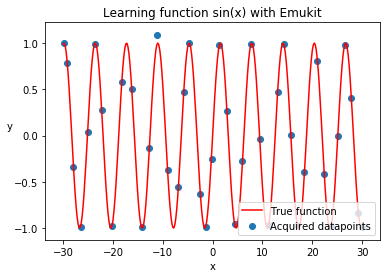

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

real_x = np.arange(x_min, x_max, 0.2)
real_y = np.sin(real_x)

plt.title('Learning function sin(x) with Emukit')
plt.xlabel('x')
plt.ylabel('y', rotation=None)
plt.plot(real_x, real_y, c='r')
plt.scatter(loop.loop_state.X[:, 0].tolist(), loop.loop_state.Y[:, 0].tolist());
plt.legend(['True function', 'Acquired datapoints'], loc='lower right');

We can also plot the trained model, to see how well it learned the function.

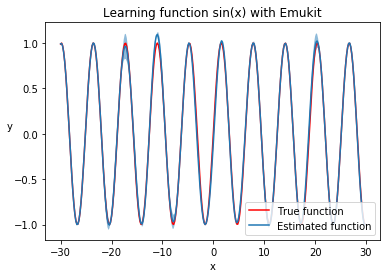

In [7]:
predicted_y = []
predicted_std = []
for x in real_x:
    y, var = emukit_model.predict(np.array([[x]]))
    std = np.sqrt(var)
    predicted_y.append(y)
    predicted_std.append(std)

predicted_y = np.array(predicted_y).flatten()
predicted_std = np.array(predicted_std).flatten()
    
plt.title('Learning function sin(x) with Emukit')
plt.xlabel('x')
plt.ylabel('y', rotation=None)
plt.plot(real_x, real_y, c='r', )
plt.plot(real_x, predicted_y)
plt.legend(['True function', 'Estimated function'], loc='lower right')
plt.fill_between(real_x, predicted_y - 2 * predicted_std, predicted_y + 2 * predicted_std, alpha=.5);